## Team name: Group4
### Simone Bellini, Student ID 567572, Kaggle name: Simone Bellini
### Miguel Baptista, Student ID 566511 Kaggle name: Miguel Baptista
### Laura Rodriguez, Student ID 566591 Kaggle name: lrodriguez2

# Main 

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, LabelEncoder, StandardScaler
from datetime import date

from matplotlib import rcParams
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import lightgbm as lgbm
import warnings
import optuna

%load_ext autoreload
%matplotlib inline

warnings.filterwarnings("ignore")

import statsmodels.api as sm
import string
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import csv

-Table description:
--
-beer_train.csv - the training set
-beer_test.csv - the test set
-sampleSubmission.csv - a sample submission file in the correct format
-id_store_sku.csv - id - store_id - sku_name mapping
-sku_features.csv - SKU Features

-Feature description:
--
-Date - calendar date
-ts_id - time-series identification, each of them describe sales of one SKU at one Store
-isPromo - how many types of promotion were active on this day. 0 = no promotions, 1 = a single promotion type (for example, -price discount), 2 = two promotion types simultaneously (for example, both price discount and special placement)-
-Sales - actual sales, target
-id - identifier of rows in the submission file (the same order as in the test set). This is the key column Kaggle uses to match the test labels and your predictions. Order matters
-Store - identifier of the stores (supermarket)
-SKU - Stock Keeping Unit. Identifier of the product
-Segment - price segment of the product
-Pack - package type
-Product - type of the drink
-Brand - product's brand
-Volume - package size

In [2]:
beer_train = pd.read_csv("data/beer_train.csv")
beer_train

,Date,ts_id,isPromo,Sales
0,2015-06-15,0,0.0,0.100
1,2015-06-15,1,0.0,0.350
2,2015-06-15,2,1.0,0.600
3,2015-06-15,3,1.0,0.350
4,2015-06-15,4,0.0,0.150
...,...,...,...,...
1382316,2017-06-14,2059,0.0,0.405
1382317,2017-06-14,2060,0.0,0.180
1382318,2017-06-14,2061,1.0,0.810
1382319,2017-06-14,2062,1.0,0.360


In [3]:
beer_test = pd.read_csv("data/beer_test.csv")

In [4]:
sampleSubmission = pd.read_csv("data/sampleSubmission.csv")

In [5]:
id_store_sku = pd.read_csv("data/id_store_sku.csv")
len(id_store_sku["Store"].unique())

267

In [6]:
sku_features = pd.read_csv("data/sku_features.csv")
sku_features

,SKU,Segment,Pack,Product,Brand,Volume
0,"_Carlsberg Can 0,45",MainStream,Can,Lager,Carlsberg,0.45
1,"_Flash Up Energy PET 0,5",High Margin,PET,Energy-drink,Flash,0.50
2,"_Holsten Bottle 0,47",Premium,Bottle,Lager,Holsten,0.50
3,"_Tuborg Green Can 0,45",Premium,Can,Lager,Tuborg,0.45
4,"_Tuborg Green Bottle 0,48",Premium,Bottle,Lager,Tuborg,0.50
5,"_Zatecky Gus Can 0,45",Premium,Can,Lager,Zatecky Gus,0.45
6,"_Zatecky Gus Bottle 0,48",Premium,Bottle,Lager,Zatecky Gus,0.50
7,"_Zatecky Gus PET 1,42",Premium,PET,Lager,Zatecky Gus,1.50
8,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
9,"_Baltika №3 Can 0,45",MainStream,Can,Lager,Baltika №3,0.45


In [7]:
result = pd.merge(id_store_sku, sku_features, on="SKU")
result

,ts_id,Store,SKU,Segment,Pack,Product,Brand,Volume
0,0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
1,6,3302,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
2,15,3303,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
3,22,3304,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
4,29,3305,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
...,...,...,...,...,...,...,...,...
1939,1248,7978,"_Baltika Cooler Bottle 0,47",MainStream,Bottle,Lager,Baltika Cooler,0.50
1940,1409,8328,"_Baltika Cooler Bottle 0,47",MainStream,Bottle,Lager,Baltika Cooler,0.50
1941,1262,7979,"_Baltika Draught PET 0,47",Premium,PET,Other,Baltika Draught,0.50
1942,1416,8328,"_Firmennoe PET 1,42",Premium,PET,Other,Firmennoe,1.50


In [8]:
final_result = pd.merge(beer_train, result, on="ts_id")
final_result[final_result["SKU"]=="	_Baltika №0 Can 0,45"]
storesOr = final_result["Store"].unique()
stores =storesOr[:5]
len(storesOr)

256

In [9]:
final_result_test = pd.merge(beer_test, result, on="ts_id")
final_result_test

,id,Date,ts_id,isPromo,Store,SKU,Segment,Pack,Product,Brand,Volume
0,0,2017-06-15,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
1,1891,2017-06-16,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
2,3782,2017-06-17,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
3,5673,2017-06-18,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
4,7564,2017-06-19,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
...,...,...,...,...,...,...,...,...,...,...,...
192877,185317,2017-09-27,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,0.45
192878,187208,2017-09-28,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,0.45
192879,189099,2017-09-29,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,0.45
192880,190990,2017-09-30,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,0.45


# Visualization (EDA)

There are 267 stores and 18 SKU in id_store_sku
There are 19 SKU in sku_features
There are 256 stores, 18 SKU, in the final join

That means that we don't have sales for 11 stores, and a beer is not sold anywhere


There are 1944 ts_id in id_store_sku
There are 1891 ts_id in beer_train and beer_test
We have 173 missing ts_id in beer_train and beer_test
We have 120 missing ts_id in id_store_sku

That means that for 53 ts_ids we don't have sales, for 120 we don't have sales either correspondance with beer/store


Date
For the train, we have 731 data points(days) for each ts_id
For the test, we have 102 data points(days) for each ts_id

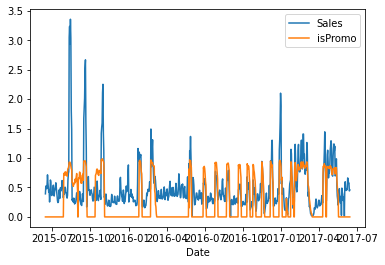

In [10]:
fr = final_result.copy(deep = True)
fr['Date'] = pd.to_datetime(final_result['Date'])

fr = fr[fr['Brand']=="Don"]
fr
res = fr.groupby(fr['Date'].dt.date).mean()  
res
plot_cols = ['Sales','isPromo']#'isPromo'
plot_features = res[plot_cols]
_ = plot_features.plot(subplots=False)

Some ts_id have a very high spike of sales some days --> we trust that the data is coherent (as suggested by TA)

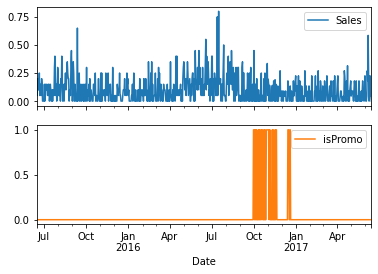

In [11]:
#Plot
ts_id0 = final_result[final_result['ts_id']==0]
date_time = pd.to_datetime(ts_id0.pop('Date'), format='%Y-%m-%d')
plot_cols = ['Sales','isPromo','Segment']
plot_features = ts_id0[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

### Effectiveness of is_Promo

PACK Can, PET, Bottle
Can : Seasonality around mid-september/begin june 2x (down) and new year/may (up)
PET : september(down)
Bottle : new year (up)

SEGMENT Premium, MainStream, High Margin
Premium : Seasonality new year (up), september/june (down)
MainStream: maybe little trend up, september/june (down) HIGH CORR WITH ISPROMO !!
High Margin: only 51 ts_id, 0 since OCT 2015, HIGH CORR WITH ISPROMO !!

PRODUCT Lager, Energy-drink, Non-alco, Other
Lager: september/june (down) new year (up)
Energy-drink: 0 since OCT 2015, GOOD CORR WITH ISPROMO !!
Non-alco: REAALLY VARIABLE,  new year (up), up in summer IS PROMO USELESS !!
Other: VERY HIGH CORR WITH ISPROMO !!

VOLUME 0.45, 0.5, 1.5
0.45: september/june (down), new year (up)
0.5: september/june (down), new year (up)
1.5: GOOD CORR WITH ISPROMO !!

STORE: TOO MANY

BRAND Carlsberg Flash Tuborg Zatecky Gus Baltika №3 Baltika №7 Baltika №9 Baltika Cooler Baltika Draught Don Firmennoe Priazovskoye
Carlsberg : HIGH CORR WITH ISPROMO !!
Flash : GOOD CORR WITH ISPROMO !!
Holsten : no data
Tuborg : GOOD CORR WITH ISPROMO !!
Zatecky Gus : GOOD CORR WITH ISPROMO !!
Baltika №3 : GOOD CORR WITH ISPROMO !!
Baltika №7 : GOOD CORR WITH ISPROMO !!
Baltika №9 : september/june (down)
Baltika Cooler : HIGH CORR WITH ISPROMO !!
Baltika Draught : HIGH CORR WITH ISPROMO !!
Don : GOOD CORR WITH ISPROMO !!
Firmennoe : GOOD CORR WITH ISPROMO !!
Priazovskoye : random

In [12]:
#TRAIN
final_result ['ProductPromoEffectiveness'] = np.where(final_result['Product'] == ("Other" or "Energy-drink"), 1, 0)
final_result ['VolumePromoEffectiveness'] = np.where(final_result['Volume'] == 1.5, 1, 0)
final_result ['BrandPromoEffectiveness'] = np.where(final_result['Brand'] != ("Baltika №9" or "Priazovskoye"), 1, 0)

#TEST
final_result_test ['ProductPromoEffectiveness'] = np.where(final_result_test['Product'] == ("Other" or "Energy-drink"), 1, 0)
final_result_test ['VolumePromoEffectiveness'] = np.where(final_result_test['Volume'] == 1.5, 1, 0)
final_result_test ['BrandPromoEffectiveness'] = np.where(final_result_test['Brand'] != ("Baltika №9" or "Priazovskoye"), 1, 0)

# Feature Engineering

### Transform into regression problem

In [13]:
#TRAIN
final_result['Year'] = pd.to_datetime(final_result['Date']).dt.year
final_result['Month'] = pd.to_datetime(final_result['Date']).dt.month
final_result['Day'] = pd.to_datetime(final_result['Date']).dt.day
final_result['Dayofweek'] = pd.to_datetime(final_result['Date']).dt.dayofweek
final_result['Week'] = pd.to_datetime(final_result['Date']).dt.isocalendar().week
final_result['Is_month_start'] = pd.to_datetime(final_result['Date']).dt.is_month_start
# #Start of month you get paid and can spend money on beers
final_result['Is_month_end'] = pd.to_datetime(final_result['Date']).dt.is_month_end
final_result['Is_year_start'] = pd.to_datetime(final_result['Date']).dt.is_year_start
final_result['Is_year_end'] = pd.to_datetime(final_result['Date']).dt.is_year_end
final_result['Is_weekend'] = np.where(final_result['Dayofweek'].isin([5,6]),1,0)
final_result['Is_weekday'] = np.where(final_result['Dayofweek'].isin([0,1,2,3,4]),1,0)

#SEASON
def get_season(date_time):
    # dummy leap year to include leap days(year-02-29) in our range
    leap_year = 2000
    seasons = [('winter', (date(leap_year, 1, 1), date(leap_year, 3, 20))),
               ('spring', (date(leap_year, 3, 21), date(leap_year, 6, 20))),
               ('summer', (date(leap_year, 6, 21), date(leap_year, 9, 22))),
               ('autumn', (date(leap_year, 9, 23), date(leap_year, 12, 20))),
               ('winter', (date(leap_year, 12, 21), date(leap_year, 12, 31)))]

    if isinstance(date_time, datetime):
        date_time = date_time.date()
    # we don't really care about the actual year so replace it with our dummy leap_year
    date_time = date_time.replace(year=leap_year)
    # return season our date falls in.
    return next(season for season, (start, end) in seasons
                if start <= date_time <= end)


# The apply method calls a function on each row
final_result['Season'] = pd.to_datetime(final_result['Date']).apply(get_season)

#BIRTHDAYS    
val = [1150200, 1137254, 1251302, 1177421, 1185114, 1242651, 1361300, 1347711, 1278152, 1312967, 1198601, 1257869]
#https://knoema.com/infographics/fjsoxbc/which-are-the-busiest-months-for-births

final_result['Birthdays'] = final_result['Month']
for x in range (1,13):
    final_result.loc[final_result['Month'] == x, 'Birthdays'] = val[x-1]/sum(val)
final_result

,Date,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,...,Dayofweek,Week,Is_month_start,Is_month_end,Is_year_start,Is_year_end,Is_weekend,Is_weekday,Season,Birthdays
0,2015-06-15,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,0,25,False,False,False,False,0,1,spring,0.083396
1,2015-06-16,0,0.0,0.050,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,1,25,False,False,False,False,0,1,spring,0.083396
2,2015-06-17,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,2,25,False,False,False,False,0,1,spring,0.083396
3,2015-06-18,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,3,25,False,False,False,False,0,1,spring,0.083396
4,2015-06-19,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,4,25,False,False,False,False,0,1,spring,0.083396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382316,2017-06-10,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,5,23,False,False,False,False,1,0,spring,0.083396
1382317,2017-06-11,2063,0.0,0.225,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,6,23,False,False,False,False,1,0,spring,0.083396
1382318,2017-06-12,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,0,24,False,False,False,False,0,1,spring,0.083396
1382319,2017-06-13,2063,0.0,0.585,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,1,24,False,False,False,False,0,1,spring,0.083396


### IsPromo

In [14]:
final_result['ts_promo'] = final_result['ts_id'].astype(str) + final_result['isPromo'].astype(str)
final_result['store_promo'] = final_result['Store'].astype(str) + final_result['isPromo'].astype(str)
final_result['segment_promo'] = final_result['Segment'].astype(str) + final_result['isPromo'].astype(str)
final_result['brand_promo'] = final_result['Brand'].astype(str) + final_result['isPromo'].astype(str)
final_result['sku_promo'] = final_result['SKU'].astype(str) + final_result['isPromo'].astype(str)

final_result['dom_promo'] = final_result['Day'].astype(str) + final_result['isPromo'].astype(str)
final_result['dow_promo'] = final_result['Dayofweek'].astype(str) + final_result['Dayofweek'].astype(str)

#### Holidays

In [15]:
holidays2015 = pd.read_csv("data/holidays2015.csv")
holidays2016 = pd.read_csv("data/holidays2016.csv")
holidays2017 = pd.read_csv("data/holidays2017.csv")

hol_nam1 = pd.DataFrame(data=holidays2015["Name"].unique())

hol_nam2 = pd.DataFrame(data=holidays2016["Name"].unique())

hol_nam3 = pd.DataFrame(data=holidays2017["Name"].unique())

date_time1 = pd.to_datetime(holidays2015.pop('Date'), format='%d-%b')
holidays2015['Date'] = date_time1
holidays2015["Date"]=holidays2015["Date"].dt.strftime("2015-%m-%d")

date_time2 = pd.to_datetime(holidays2016.pop('Date'), format='%d-%b')
holidays2016['Date'] = date_time2
holidays2016["Date"]=holidays2016["Date"].dt.strftime("2016-%m-%d")

date_time3 = pd.to_datetime(holidays2017.pop('Date'), format='%d-%b')
holidays2017['Date'] = date_time3
holidays2017["Date"]=holidays2017["Date"].dt.strftime("2017-%m-%d")

result_holidays = pd.merge(
    hol_nam1,
    hol_nam2,
    how="outer"
)

result_holidays = pd.merge(
    result_holidays,
    hol_nam3,
    how="outer"
)
names_holidays = list(result_holidays[0])

matrix = np.zeros((len(final_result),len(names_holidays)))
holidays_df = pd.DataFrame(matrix,
                   columns=names_holidays)

final_result = final_result.join(holidays_df)

aux = 0
for index, row in final_result.iterrows():
    if row['Year']==2015:
        indexes = [i for i, e in enumerate(list(holidays2015['Date'])) if e == row['Date']]
        if indexes :
            for ind in indexes:
                final_result.at[index, holidays2015['Name'][ind]]=1
                final_result.at[index,"Holiday"] = holidays2015['Name'][ind]
        else:
            final_result.at[index, "Holiday"]="Not Holiday"

    if row['Year']==2016:
        indexes = [i for i, e in enumerate(list(holidays2016['Date'])) if e == row['Date']]
        if indexes :
            for ind in indexes:
                final_result.at[index,holidays2016['Name'][ind]]=1
                final_result.at[index, "Holiday"]=holidays2016['Name'][ind]
        else:
            final_result.at[index, "Holiday"]="Not Holiday"

    if row['Year']==2017:
        indexes = [i for i, e in enumerate(list(holidays2017['Date'])) if e == row['Date']]
        if indexes :
            for ind in indexes:
                final_result.at[index , holidays2017['Name'][ind]]=1
                final_result.at[index, "Holiday"]=holidays2017['Name'][ind]
        else:
            final_result.at[index, "Holiday"]="Not Holiday"

final_result

,Date,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,...,Muharram,Unity Day,December Solstice,New Year Holiday Substitution,Day off for Spring and Labor Day,Day off for Russia Day,Extra holiday in lieu of Jan. 1,Extra holiday in lieu of Jan. 7,Day off for Unity Day,Holiday
0,2015-06-15,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Holiday
1,2015-06-16,0,0.0,0.050,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Holiday
2,2015-06-17,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Holiday
3,2015-06-18,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ramadan starts
4,2015-06-19,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382316,2017-06-10,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Holiday
1382317,2017-06-11,2063,0.0,0.225,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Holiday
1382318,2017-06-12,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Russia Day
1382319,2017-06-13,2063,0.0,0.585,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Holiday


In [16]:
final_result = final_result.drop(holidays_df,axis=1)
final_result

,Date,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,...,Season,Birthdays,ts_promo,store_promo,segment_promo,brand_promo,sku_promo,dom_promo,dow_promo,Holiday
0,2015-06-15,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",150.0,00,Not Holiday
1,2015-06-16,0,0.0,0.050,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",160.0,11,Not Holiday
2,2015-06-17,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",170.0,22,Not Holiday
3,2015-06-18,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",180.0,33,Ramadan starts
4,2015-06-19,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",190.0,44,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382316,2017-06-10,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",100.0,55,Not Holiday
1382317,2017-06-11,2063,0.0,0.225,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",110.0,66,Not Holiday
1382318,2017-06-12,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",120.0,00,Russia Day
1382319,2017-06-13,2063,0.0,0.585,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",130.0,11,Not Holiday


In [17]:
#TEST SET
final_result_test['Year'] = pd.to_datetime(final_result_test['Date']).dt.year
final_result_test['Month'] = pd.to_datetime(final_result_test['Date']).dt.month
final_result_test['Day'] = pd.to_datetime(final_result_test['Date']).dt.day
final_result_test['Dayofweek'] = pd.to_datetime(final_result_test['Date']).dt.dayofweek
final_result_test['Week'] = pd.to_datetime(final_result_test['Date']).dt.isocalendar().week
final_result_test['Is_month_start'] = pd.to_datetime(final_result_test['Date']).dt.is_month_start
# #Start of month you get paid and can spend money on beers
final_result_test['Is_month_end'] = pd.to_datetime(final_result_test['Date']).dt.is_month_end
final_result_test['Is_year_start'] = pd.to_datetime(final_result_test['Date']).dt.is_year_start
final_result_test['Is_year_end'] = pd.to_datetime(final_result_test['Date']).dt.is_year_end
final_result_test['Is_weekend'] = np.where(final_result_test['Dayofweek'].isin([5,6]),1,0)
final_result_test['Is_weekday'] = np.where(final_result_test['Dayofweek'].isin([0,1,2,3,4]),1,0)

#SEASON
# The apply method calls a function on each row
final_result_test['Season'] = pd.to_datetime(final_result_test['Date']).apply(get_season)

#BIRTHDAYS    
val = [1150200, 1137254, 1251302, 1177421, 1185114, 1242651, 1361300, 1347711, 1278152, 1312967, 1198601, 1257869]
#https://knoema.com/infographics/fjsoxbc/which-are-the-busiest-months-for-births

final_result_test['Birthdays'] = final_result_test['Month']
for x in range (1,13):
    final_result_test.loc[final_result_test['Month'] == x, 'Birthdays'] = val[x-1]/sum(val)

### IsPromo

In [18]:
final_result_test['ts_promo'] = final_result_test['ts_id'].astype(str) + final_result_test['isPromo'].astype(str)
final_result_test['store_promo'] = final_result_test['Store'].astype(str) + final_result_test['isPromo'].astype(str)
final_result_test['segment_promo'] = final_result_test['Segment'].astype(str) + final_result_test['isPromo'].astype(str)
final_result_test['brand_promo'] = final_result_test['Brand'].astype(str) + final_result_test['isPromo'].astype(str)
final_result_test['sku_promo'] = final_result_test['SKU'].astype(str) + final_result_test['isPromo'].astype(str)

final_result_test['dom_promo'] = final_result_test['Day'].astype(str) + final_result_test['isPromo'].astype(str)
final_result_test['dow_promo'] = final_result_test['Dayofweek'].astype(str) + final_result_test['isPromo'].astype(str)

#### Holidays test

In [19]:
matrix = np.zeros((len(final_result_test),len(names_holidays)))
holidays_df = pd.DataFrame(matrix,
                   columns=names_holidays)

aux = 0
for index, row in final_result_test.iterrows():
    if row['Year']==2015:
        indexes = [i for i, e in enumerate(list(holidays2015['Date'])) if e == row['Date']]
        if indexes :
            for ind in indexes:
                final_result_test.at[index, holidays2015['Name'][ind]]=1
                final_result_test.at[index,"Holiday"] = holidays2015['Name'][ind]
        else:
            final_result_test.at[index, "Holiday"]="Not Holiday"

    if row['Year']==2016:
        indexes = [i for i, e in enumerate(list(holidays2016['Date'])) if e == row['Date']]
        if indexes :
            for ind in indexes:
                final_result_test.at[index,holidays2016['Name'][ind]]=1
                final_result_test.at[index, "Holiday"]=holidays2016['Name'][ind]
        else:
            final_result_test.at[index, "Holiday"]="Not Holiday"

    if row['Year']==2017:
        indexes = [i for i, e in enumerate(list(holidays2017['Date'])) if e == row['Date']]
        if indexes :
            for ind in indexes:
                final_result_test.at[index , holidays2017['Name'][ind]]=1
                final_result_test.at[index, "Holiday"]=holidays2017['Name'][ind]
        else:
            final_result_test.at[index, "Holiday"]="Not Holiday"

final_result_test

,id,Date,ts_id,isPromo,Store,SKU,Segment,Pack,Product,Brand,...,dom_promo,dow_promo,Holiday,Lailat al-Qadr,June Solstice,Eid al-Fitr,Day of Knowledge,Eid al-Adha,Muharram,September Equinox
0,0,2017-06-15,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,150.0,30.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1891,2017-06-16,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,160.0,40.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3782,2017-06-17,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,170.0,50.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5673,2017-06-18,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,180.0,60.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7564,2017-06-19,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,190.0,00.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192877,185317,2017-09-27,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,270.0,20.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192878,187208,2017-09-28,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,280.0,30.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192879,189099,2017-09-29,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,290.0,40.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192880,190990,2017-09-30,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,300.0,50.0,Not Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
final_result_test = final_result_test.drop(['Lailat al-Qadr','June Solstice','Eid al-Fitr','Day of Knowledge','Eid al-Adha','Muharram','September Equinox'],axis=1)
final_result_test

,id,Date,ts_id,isPromo,Store,SKU,Segment,Pack,Product,Brand,...,Season,Birthdays,ts_promo,store_promo,segment_promo,brand_promo,sku_promo,dom_promo,dow_promo,Holiday
0,0,2017-06-15,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",150.0,30.0,Not Holiday
1,1891,2017-06-16,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",160.0,40.0,Not Holiday
2,3782,2017-06-17,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",170.0,50.0,Not Holiday
3,5673,2017-06-18,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",180.0,60.0,Not Holiday
4,7564,2017-06-19,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",190.0,00.0,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192877,185317,2017-09-27,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",270.0,20.0,Not Holiday
192878,187208,2017-09-28,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",280.0,30.0,Not Holiday
192879,189099,2017-09-29,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",290.0,40.0,Not Holiday
192880,190990,2017-09-30,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",300.0,50.0,Not Holiday


# Data cleaning

In [21]:
#Find if there are duplicates
final_result = pd.DataFrame.drop_duplicates(final_result)# Nothing happens
beer_test = pd.DataFrame.drop_duplicates(beer_test)# Nothing happens


In [22]:
#Find if there are nan
final_result.isnull().sum().sum() #No nan found
beer_test.isnull().sum().sum() #No nan found

0

## Save

In [23]:
# final_result.to_csv("train_preprocessed.csv", index=False)
# final_result_test.to_csv("test_preprocessed.csv", index=False)

# Extra Exploring 

In [24]:
beer_test = pd.read_csv("data/beer_test.csv")

In [25]:
sampleSubmission = pd.read_csv("data/sampleSubmission.csv")

In [26]:
id_store_sku = pd.read_csv("data/id_store_sku.csv")
len(id_store_sku["Store"].unique())

267

In [27]:
sku_features = pd.read_csv("data/sku_features.csv")
sku_features

,SKU,Segment,Pack,Product,Brand,Volume
0,"_Carlsberg Can 0,45",MainStream,Can,Lager,Carlsberg,0.45
1,"_Flash Up Energy PET 0,5",High Margin,PET,Energy-drink,Flash,0.50
2,"_Holsten Bottle 0,47",Premium,Bottle,Lager,Holsten,0.50
3,"_Tuborg Green Can 0,45",Premium,Can,Lager,Tuborg,0.45
4,"_Tuborg Green Bottle 0,48",Premium,Bottle,Lager,Tuborg,0.50
5,"_Zatecky Gus Can 0,45",Premium,Can,Lager,Zatecky Gus,0.45
6,"_Zatecky Gus Bottle 0,48",Premium,Bottle,Lager,Zatecky Gus,0.50
7,"_Zatecky Gus PET 1,42",Premium,PET,Lager,Zatecky Gus,1.50
8,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
9,"_Baltika №3 Can 0,45",MainStream,Can,Lager,Baltika №3,0.45


In [28]:
beer_train = pd.read_csv("data/beer_train.csv")
beer_train

,Date,ts_id,isPromo,Sales
0,2015-06-15,0,0.0,0.100
1,2015-06-15,1,0.0,0.350
2,2015-06-15,2,1.0,0.600
3,2015-06-15,3,1.0,0.350
4,2015-06-15,4,0.0,0.150
...,...,...,...,...
1382316,2017-06-14,2059,0.0,0.405
1382317,2017-06-14,2060,0.0,0.180
1382318,2017-06-14,2061,1.0,0.810
1382319,2017-06-14,2062,1.0,0.360


In [29]:
id_store_sku["ts_id"].unique()

array([   0,    1,    2, ..., 2061, 2062, 2063], dtype=int64)

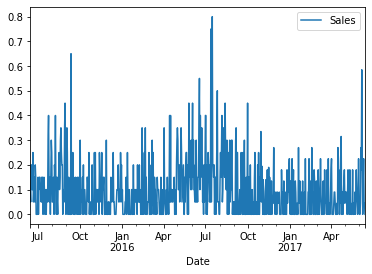

In [30]:
beer_train = pd.read_csv("data/beer_train.csv")
ts_id0 = beer_train[beer_train['ts_id']==0]
date_time = pd.to_datetime(ts_id0.pop('Date'), format='%Y-%m-%d')
plot_cols = ['Sales']
plot_features = ts_id0[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [31]:
result = pd.merge(id_store_sku, sku_features, on="SKU")
result

,ts_id,Store,SKU,Segment,Pack,Product,Brand,Volume
0,0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
1,6,3302,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
2,15,3303,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
3,22,3304,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
4,29,3305,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,0.45
...,...,...,...,...,...,...,...,...
1939,1248,7978,"_Baltika Cooler Bottle 0,47",MainStream,Bottle,Lager,Baltika Cooler,0.50
1940,1409,8328,"_Baltika Cooler Bottle 0,47",MainStream,Bottle,Lager,Baltika Cooler,0.50
1941,1262,7979,"_Baltika Draught PET 0,47",Premium,PET,Other,Baltika Draught,0.50
1942,1416,8328,"_Firmennoe PET 1,42",Premium,PET,Other,Firmennoe,1.50


In [32]:
final_result = pd.merge(beer_train, result, on="ts_id")
final_result[final_result["SKU"]=="	_Baltika №0 Can 0,45"]
storesOr = final_result["Store"].unique()
stores =storesOr[:5]
len(storesOr)

256

Store 3301
Store 3302
Store 3303
Store 3304
Store 3305


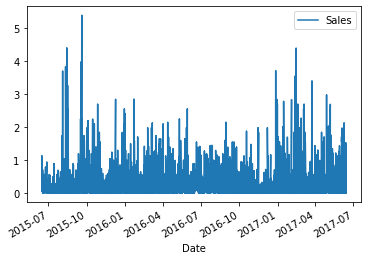

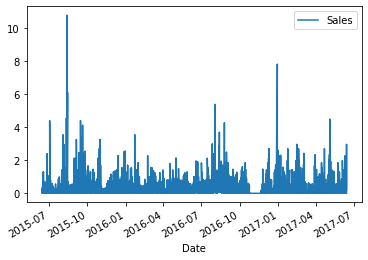

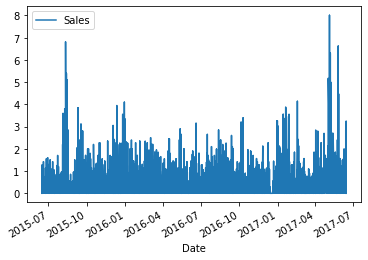

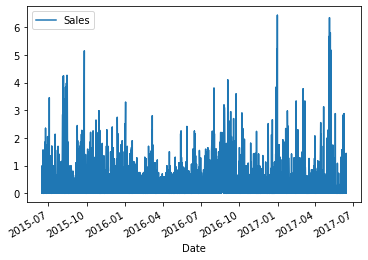

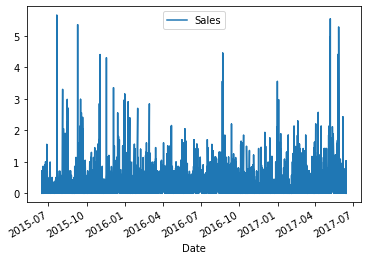

In [33]:
for s in stores:
    ts_id0 = final_result[final_result['Store']==s]
    print("Store",s)
    date_time = pd.to_datetime(ts_id0.pop('Date'), format='%Y-%m-%d')
    plot_cols = ['Sales']
    plot_features = ts_id0[plot_cols]
    plot_features.index = date_time
    _ = plot_features.plot(subplots=True)

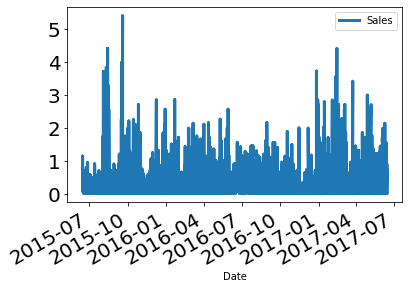

In [34]:
ts_id0 = final_result[final_result['Store']==stores[0]]
date_time = pd.to_datetime(ts_id0.pop('Date'), format='%Y-%m-%d')
plot_cols = ['Sales']
plot_features = ts_id0[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(linewidth =3, fontsize=20,subplots=True)

## Preprocesing

In [35]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [36]:
print('Number of Training Examples = {}'.format(final_result.shape[0]))
print('Training X Shape = {}'.format(final_result.shape))
print('Training y Shape = {}'.format(final_result['Sales'].shape[0]))
print('Train columns \n', list(final_result.columns))

Number of Training Examples = 1382321
Training X Shape = (1382321, 11)
Training y Shape = 1382321
Train columns 
 ['Date', 'ts_id', 'isPromo', 'Sales', 'Store', 'SKU', 'Segment', 'Pack', 'Product', 'Brand', 'Volume']


In [37]:
print(final_result.info())
final_result.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382321 entries, 0 to 1382320
Data columns (total 11 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Date     1382321 non-null  object 
 1   ts_id    1382321 non-null  int64  
 2   isPromo  1382321 non-null  float64
 3   Sales    1382321 non-null  float64
 4   Store    1382321 non-null  object 
 5   SKU      1382321 non-null  object 
 6   Segment  1382321 non-null  object 
 7   Pack     1382321 non-null  object 
 8   Product  1382321 non-null  object 
 9   Brand    1382321 non-null  object 
 10  Volume   1382321 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 126.6+ MB
None


,Date,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,Volume
1188192,2016-04-27,1751,0.0,0.55,9908,"_Baltika №7 Can 0,45",Premium,Can,Lager,Baltika №7,0.45
890715,2016-06-06,1344,0.0,0.00,8058,"_Zatecky Gus PET 1,42",Premium,PET,Lager,Zatecky Gus,1.50
57362,2016-05-24,92,0.0,0.15,3321,"_Baltika №3 Can 0,45",MainStream,Can,Lager,Baltika №3,0.45


In [38]:
non_numeric_features = ['Store', 'SKU', 'Segment', 'Pack', 'Product', 'Brand']

for feature in non_numeric_features:        
    final_result[feature] = LabelEncoder().fit_transform(final_result[feature])
    final_result[feature] = LabelEncoder().fit_transform(final_result[feature])

In [39]:
aux=final_result.sample(100)
aux.columns

Index(['Date', 'ts_id', 'isPromo', 'Sales', 'Store', 'SKU', 'Segment', 'Pack',
       'Product', 'Brand', 'Volume'],
      dtype='object')

In [40]:
date_time = pd.to_datetime(final_result.pop('Date'), format='%Y-%m-%d')
final_result['Date'] = date_time
final_result

,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,Volume,Date
0,0,0.0,0.100,0,2,2,1,2,2,0.45,2015-06-15
1,0,0.0,0.050,0,2,2,1,2,2,0.45,2015-06-16
2,0,0.0,0.200,0,2,2,1,2,2,0.45,2015-06-17
3,0,0.0,0.200,0,2,2,1,2,2,0.45,2015-06-18
4,0,0.0,0.100,0,2,2,1,2,2,0.45,2015-06-19
...,...,...,...,...,...,...,...,...,...,...,...
1382316,2063,0.0,0.315,255,6,1,1,1,4,0.45,2017-06-10
1382317,2063,0.0,0.225,255,6,1,1,1,4,0.45,2017-06-11
1382318,2063,0.0,0.315,255,6,1,1,1,4,0.45,2017-06-12
1382319,2063,0.0,0.585,255,6,1,1,1,4,0.45,2017-06-13


In [41]:
final_result[final_result['Store']==0]

,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,Volume,Date
0,0,0.0,0.100,0,2,2,1,2,2,0.45,2015-06-15
1,0,0.0,0.050,0,2,2,1,2,2,0.45,2015-06-16
2,0,0.0,0.200,0,2,2,1,2,2,0.45,2015-06-17
3,0,0.0,0.200,0,2,2,1,2,2,0.45,2015-06-18
4,0,0.0,0.100,0,2,2,1,2,2,0.45,2015-06-19
...,...,...,...,...,...,...,...,...,...,...,...
4381,5,0.0,0.000,0,8,1,2,3,6,1.50,2017-06-10
4382,5,0.0,0.000,0,8,1,2,3,6,1.50,2017-06-11
4383,5,0.0,0.000,0,8,1,2,3,6,1.50,2017-06-12
4384,5,0.0,0.568,0,8,1,2,3,6,1.50,2017-06-13


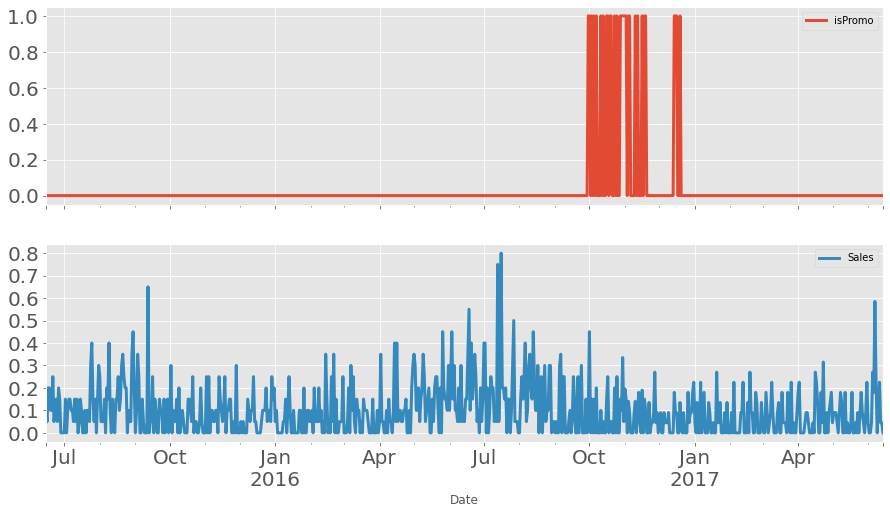

In [42]:
# aux.plot(figsize=(20,10),linewidth =4, fontsize=20,subplots=True)
# plt.xlabel('Date',fontsize=20)
aux=final_result[final_result['ts_id']==0]
date_time = pd.to_datetime(aux.pop('Date'), format='%Y-%m-%d')
plot_cols = ['isPromo','Sales']
plot_features = aux[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(figsize=(15,8),linewidth =3, fontsize=20,subplots=True)

### Trend

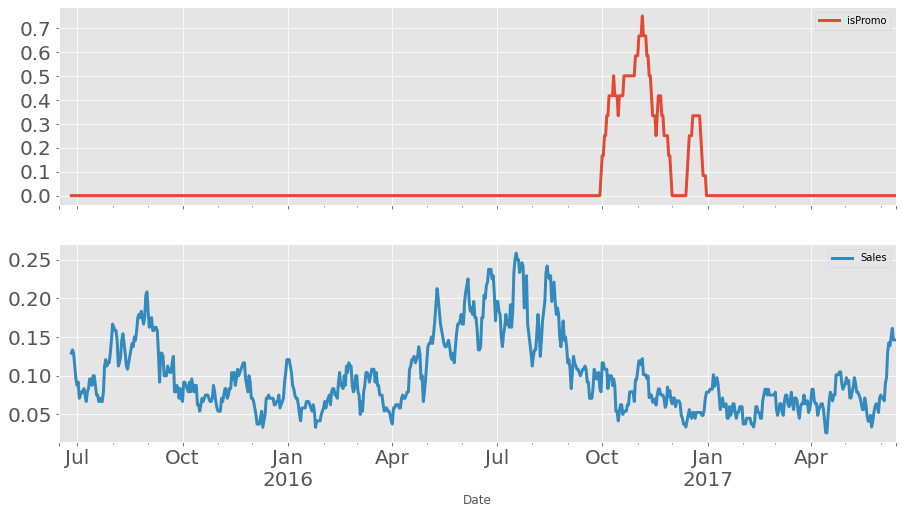

In [43]:
# date = aux[['Sales']]
# date.rolling(12).mean().plot(figsize=(20,10),linewidth =4, fontsize=20)
# plt.xlabel('Date',fontsize=20)

aux=final_result[final_result['ts_id']==0]
date_time = pd.to_datetime(aux.pop('Date'), format='%Y-%m-%d')
plot_cols = ['isPromo','Sales']
plot_features = aux[plot_cols]
plot_features.index = date_time
_ = plot_features.rolling(12).mean().plot(figsize=(15,8),linewidth =3, fontsize=20,subplots=True)

### Seasonality

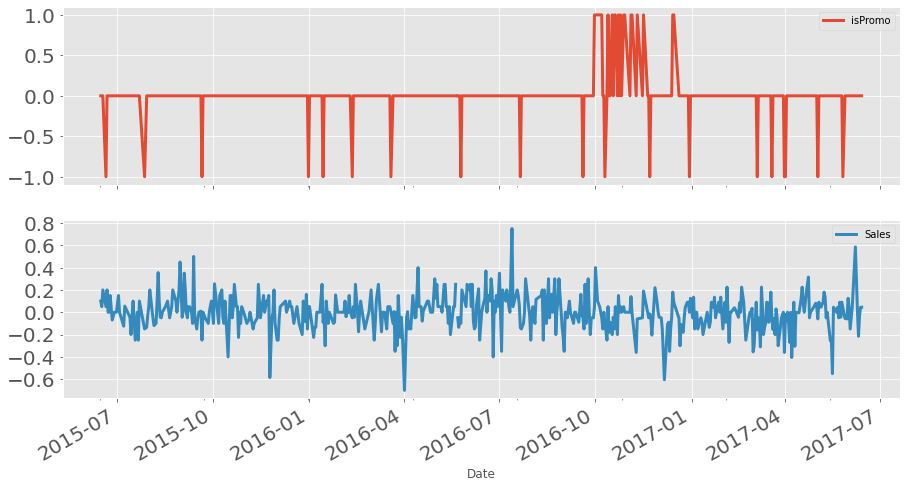

In [44]:
# date.diff().plot(figsize=(20,10),linewidth =4, fontsize=20)
# plt.xlabel('Date',fontsize=20)

aux=final_result[final_result['ts_id']==0].sample(500)
date_time = pd.to_datetime(aux.pop('Date'), format='%Y-%m-%d')
plot_cols = ['isPromo','Sales']
plot_features = aux[plot_cols]
plot_features.index = date_time
_ = plot_features.diff().plot(figsize=(15,8),linewidth =3, fontsize=20,subplots=True)

# Special Beer

In [45]:
aux=final_result[final_result['ts_id']==0] 
aux.pop('ts_id')
aux.pop('SKU')
aux.pop('Segment')
aux.pop('Pack')
aux.pop('Product')
aux.pop('Brand')
aux.pop('Volume')
aux.pop('Store')
aux.set_index('Date',inplace=True)
aux.head()

,isPromo,Sales
Date,,
2015-06-15,0.0,0.10
2015-06-16,0.0,0.05
2015-06-17,0.0,0.20
2015-06-18,0.0,0.20
2015-06-19,0.0,0.10


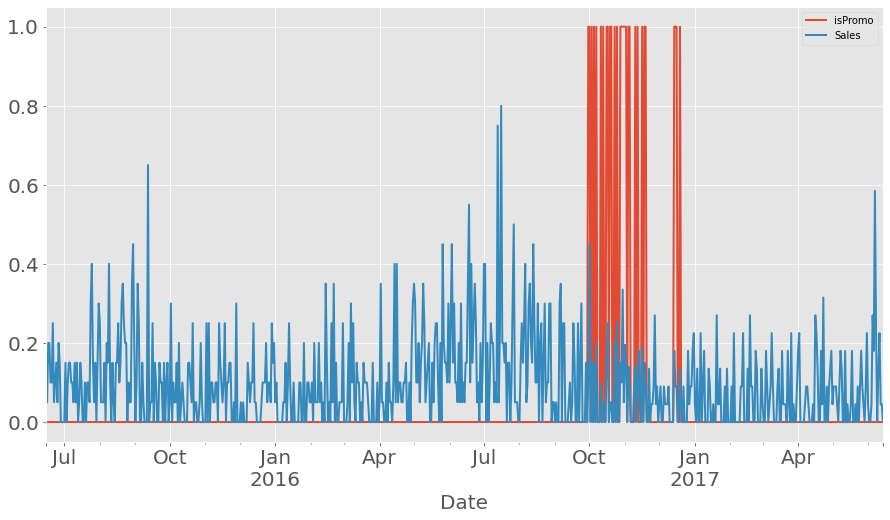

In [46]:
aux.plot(figsize=(15,8),linewidth =2, fontsize=20)
plt.xlabel('Date',fontsize=20);

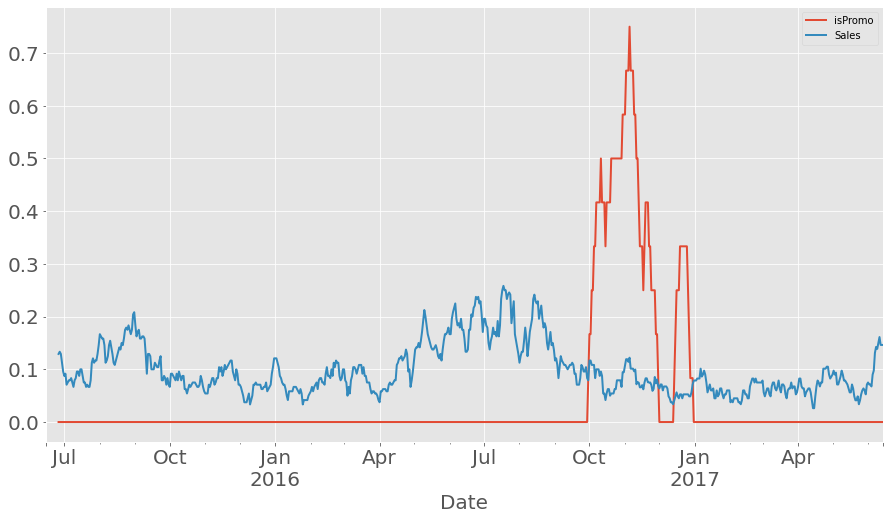

In [47]:
# TRend
aux.rolling(12).mean().plot(figsize=(15,8),linewidth =2, fontsize=20)
plt.xlabel('Date',fontsize=20);

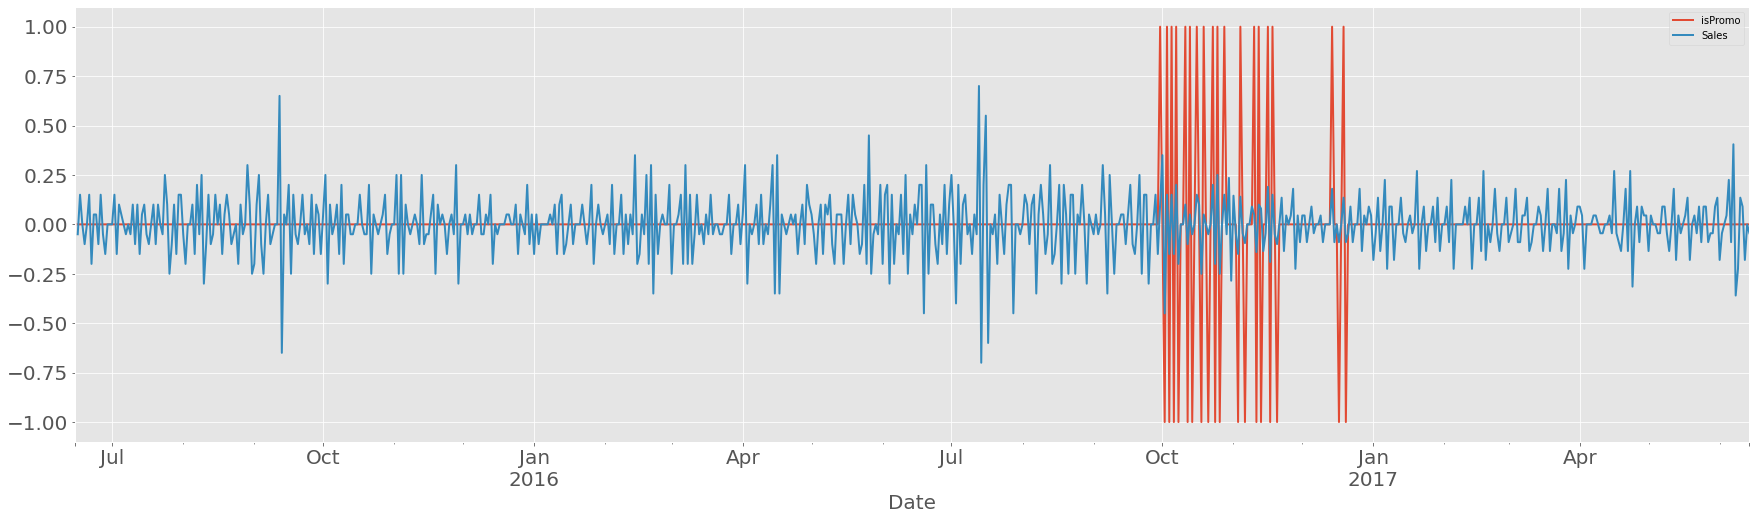

In [48]:
# Seasonality
aux.diff().plot(figsize=(30,8),linewidth =2, fontsize=20)
plt.xlabel('Date',fontsize=20);

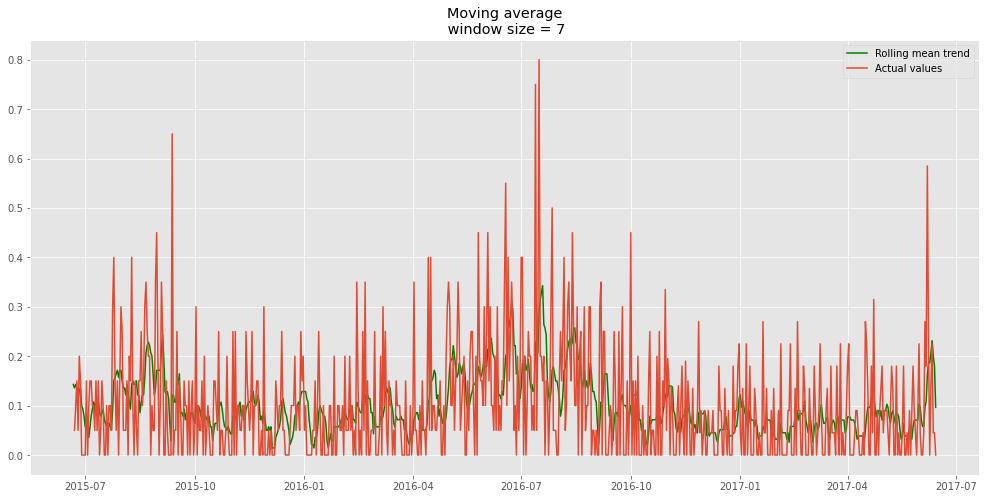

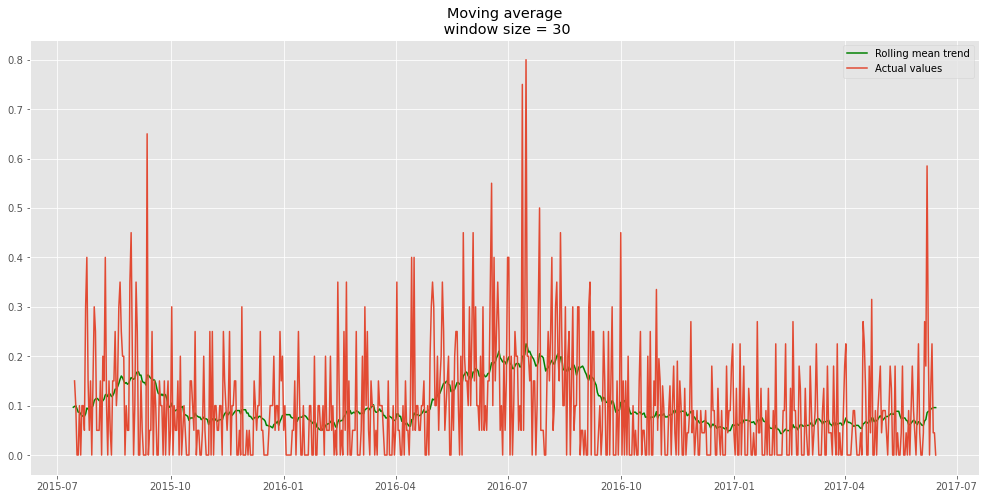

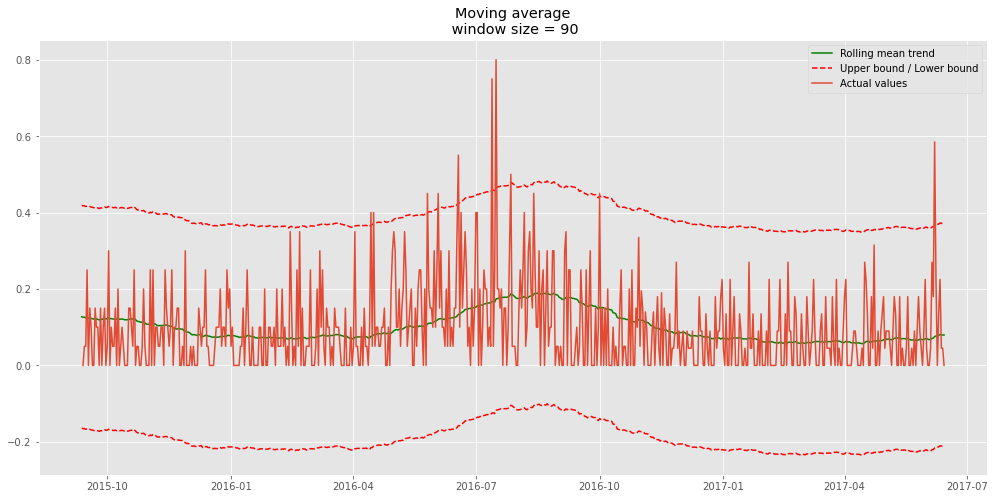

In [49]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 7 days (by week)
plot_moving_average(aux.Sales, 7)

#Smooth by the previous month (30 days)
plot_moving_average(aux.Sales, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(aux.Sales, 90, plot_intervals=True)

#### Exponential smoothing to see if it can pick up a better trend

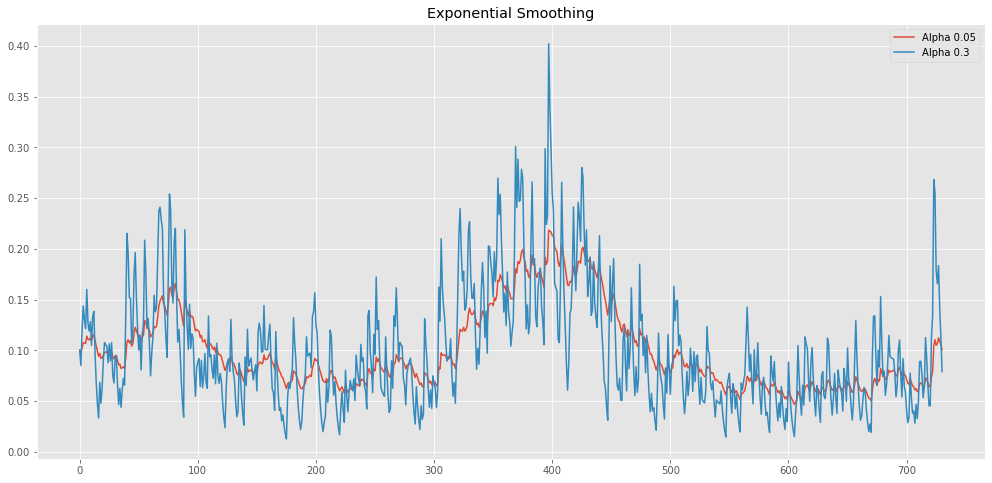

In [50]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    # Uncoment the next line if you want to see how the data actually behaves
#     plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(aux.Sales, [0.05, 0.3])

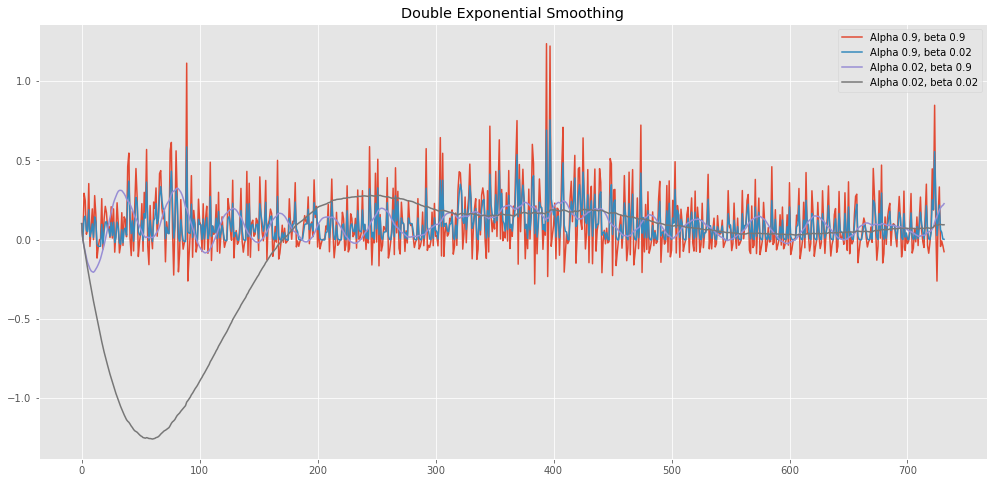

In [51]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
#     plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(aux.Sales, alphas=[0.9, 0.02], betas=[0.9, 0.02])

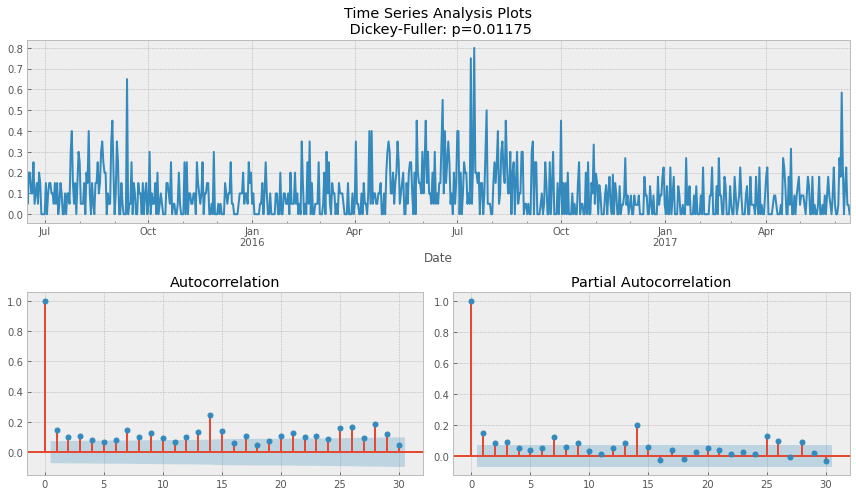

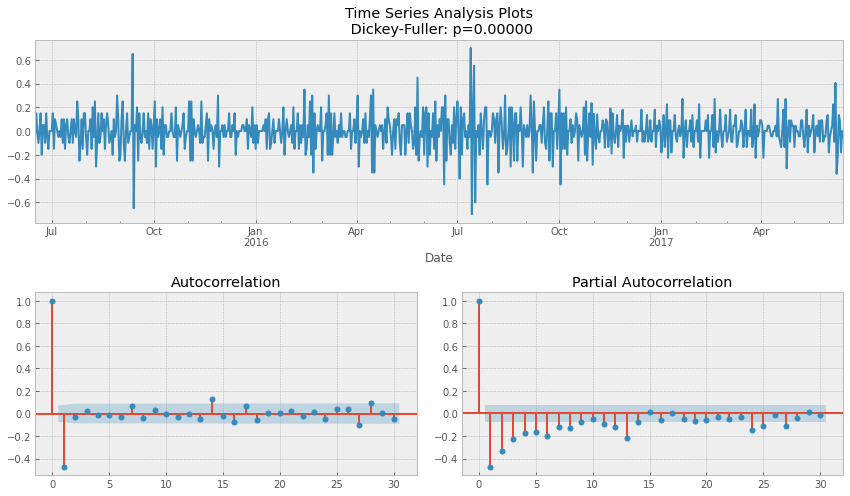

In [52]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(aux.Sales, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = aux.Sales - aux.Sales.shift(1)

tsplot(data_diff[1:], lags=30)

# LGBM - Catboost Simone

## Import data and small preprocessing

In [55]:
trainData = pd.read_csv("train_preprocessed.csv",dtype={'Store': object,'ts_promo': object,'store_promo': object,'dom_promo': object,'dow_promo': object})
trainData['Date'] = pd.to_datetime(trainData['Date'])
trainData

,Date,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,...,Season,Birthdays,ts_promo,store_promo,segment_promo,brand_promo,sku_promo,dom_promo,dow_promo,Holiday
0,2015-06-15,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",150.0,00,Not Holiday
1,2015-06-16,0,0.0,0.050,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",160.0,11,Not Holiday
2,2015-06-17,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",170.0,22,Not Holiday
3,2015-06-18,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",180.0,33,Ramadan starts
4,2015-06-19,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",190.0,44,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382316,2017-06-10,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",100.0,55,Not Holiday
1382317,2017-06-11,2063,0.0,0.225,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",110.0,66,Not Holiday
1382318,2017-06-12,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",120.0,00,Russia Day
1382319,2017-06-13,2063,0.0,0.585,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",130.0,11,Not Holiday


In [57]:
testData = pd.read_csv("test_preprocessed.csv",dtype={'Store': object,'ts_promo': object,'store_promo': object,'dom_promo': object,'dow_promo': object})
testData['Date'] = pd.to_datetime(testData['Date'])
testData

,id,Date,ts_id,isPromo,Store,SKU,Segment,Pack,Product,Brand,...,Season,Birthdays,ts_promo,store_promo,segment_promo,brand_promo,sku_promo,dom_promo,dow_promo,Holiday
0,0,2017-06-15,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",150.0,30.0,Not Holiday
1,1891,2017-06-16,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",160.0,40.0,Not Holiday
2,3782,2017-06-17,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",170.0,50.0,Not Holiday
3,5673,2017-06-18,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",180.0,60.0,Not Holiday
4,7564,2017-06-19,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",190.0,00.0,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192877,185317,2017-09-27,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",270.0,20.0,Not Holiday
192878,187208,2017-09-28,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",280.0,30.0,Not Holiday
192879,189099,2017-09-29,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",290.0,40.0,Not Holiday
192880,190990,2017-09-30,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",300.0,50.0,Not Holiday


In [58]:
for c in trainData.columns:
    col_type = trainData[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        trainData[c] = trainData[c].astype('category')

In [59]:
for c in testData.columns:
    col_type = testData[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        testData[c] = testData[c].astype('category')

In [60]:
print(trainData['Date'].is_monotonic_increasing)
print(testData['Date'].is_monotonic_increasing)
trainData = trainData.sort_values(by=['Date'])
testData = testData.sort_values(by=['Date'])

False
False


In [61]:
X = trainData.drop(['Sales','Date'], axis=1)#Date
y = trainData['Sales']

In [62]:
var_categ =[]
for c in X.columns:
    col_type = X[c].dtype
    if col_type.name == 'category':
        var_categ.append(c)
var_categ

['Store',
 'SKU',
 'Segment',
 'Pack',
 'Product',
 'Brand',
 'Season',
 'ts_promo',
 'store_promo',
 'segment_promo',
 'brand_promo',
 'sku_promo',
 'dom_promo',
 'dow_promo',
 'Holiday']

# LGBM

## Get best hyperparam

In [ ]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# lgbm = LGBMRegressor(
#     silent=True, 
#     n_jobs=-1, 
#     #device = "gpu"
#     )

# search_space = {"boosting_type": Categorical(['dart']),
#         "num_leaves": Integer(6, 60), 
#         "max_depth": Integer(-1, 40), 
#         "learning_rate": Real(0.001,1),
#         "n_estimators": Integer(2, 1000),
#         "subsample_for_bin": Integer(195000, 204000),
#         "colsample_bytree" : Real (0.5,1.0),#New
#         "subsample": Real (0.5,1.0) #New
#     }
# cv = TimeSeriesSplit(n_splits=7)

# bayes_cv_tuner = BayesSearchCV(
#     estimator = lgbm, 
#     search_spaces =search_space, 
#     n_iter=20, # specify how many iterations
#     scoring="neg_root_mean_squared_error",
#     cv=cv,
#     verbose=0,
#     n_jobs =-1
# )

# def print_status(optimal_result):
#     """Shows the best parameters found and accuracy attained of the search so far."""
#     print("Done")

# bayes_cv_tuner.fit(X, y, callback=print_status) # .iloc[1:500]

In [ ]:
# bayes_cv_tuner.best_params_

In [ ]:
# print(type(bayes_cv_tuner.best_params_))

# keys, values = [], []
# for key, value in bayes_cv_tuner.best_params_.items():
#     keys.append(key)
#     values.append(value)       

# with open("LGBMBestParam.csv", "w") as outfile:
#     csvwriter = csv.writer(outfile)
#     csvwriter.writerow(keys)
#     csvwriter.writerow(values)

In [ ]:
# bayes_cv_tuner.best_score_

In [ ]:
# from skopt.plots import plot_convergence

# plot_convergence(result) 

## Apply

In [64]:
lgbm = LGBMRegressor(
    boosting_type = 'dart',
    learning_rate = 0.35878911553612336, 
    max_depth = 1,
    metric='rmse',
    n_estimators = 524,
    num_leaves = 21,
    subsample_for_bin = 199000,
    colsample_bytree = 0.8,
    subsample = 1.0,
    silent=True
    )
#BestParam
# [('boosting_type', 'dart'),#1
#              ('learning_rate', 0.039741509928932967),
#              ('max_depth', 10), #Max
#              ('n_estimators', 336),
#              ('num_leaves', 26),
#              ('subsample_for_bin', 201000)]) #Max

# [('boosting_type', 'dart'),#2
#              ('learning_rate', 0.4013806578117077),
#              ('max_depth', 14),
#              ('n_estimators', 113),
#              ('num_leaves', 8),
#              ('subsample_for_bin', 199119)])
# ([('boosting_type', 'dart'),#3 best
#              ('colsample_bytree', 0.8),
#              ('learning_rate', 0.35878911553612336),
#              ('max_depth', 1),
#              ('n_estimators', 524),
#              ('num_leaves', 21),
#              ('subsample', 1.0),
#              ('subsample_for_bin', 199000)])
# [('boosting_type', 'dart'), #4
#              ('colsample_bytree', 0.7423119611889375),
#              ('learning_rate', 0.7376761996696818),
#              ('max_depth', 1),
#              ('n_estimators', 61),
#              ('num_leaves', 7),
#              ('subsample', 0.6455963683564654),
#              ('subsample_for_bin', 204000)])

In [65]:
#TSCV
# tscv = TimeSeriesSplit(n_splits=7)
# rmse=[]
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     lgbm.fit(X_train,y_train)
#     lgbm_prediction = lgbm.predict(X_test)
#     rmse.append(round(mean_squared_error(lgbm_prediction, y_test,squared=False), 2))
    
# average_rmse = np.mean(rmse)
# print(average_rmse)

testX = testData.drop(['id','Date'], axis=1)
if 'Sales' in testX.columns:
    testX = testX.drop(['Sales'], axis=1)

#Now all data
lgbm.fit(X,y)
lgbm_prediction = lgbm.predict(testX)

testData['Sales'] = lgbm_prediction
testData = testData.sort_values(by=['id'])
print(testData)
testData[['id','Sales']].to_csv("LGBMsubmission.csv", index=False)


            id       Date  ts_id  isPromo Store                      SKU  \
0            0 2017-06-15      0      0.0  3301     _Baltika №0 Can 0,45   
102          1 2017-06-15      1      1.0  3301     _Baltika №3 Can 0,45   
204          2 2017-06-15      2      1.0  3301     _Baltika №7 Can 0,45   
306          3 2017-06-15      3      1.0  3301  _Baltika №7 Bottle 0,47   
408          4 2017-06-15      4      0.0  3301     _Baltika №9 Can 0,45   
...        ...        ...    ...      ...   ...                      ...   
192473  192877 2017-10-01   2059      0.0  Q096      _Carlsberg Can 0,45   
192575  192878 2017-10-01   2060      1.0  Q096     _Baltika №0 Can 0,45   
192677  192879 2017-10-01   2061      0.0  Q096     _Baltika №3 Can 0,45   
192779  192880 2017-10-01   2062      1.0  Q096     _Baltika №7 Can 0,45   
192881  192881 2017-10-01   2063      0.0  Q096     _Baltika №9 Can 0,45   

           Segment    Pack   Product       Brand  ...  Birthdays  ts_promo  \
0        

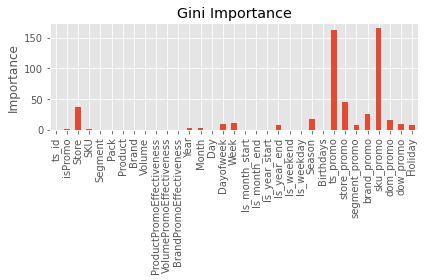

In [66]:
importances = lgbm.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

The feature related to is_promo (like ts_promo or sku_promo) are highly considered by the algorithm, while surprisingly is_promo is not. The algorithm seems to give no importance to the promo effectiveness and features related to the specific beer (like Segment, Pack, Product..)

In [67]:
lgbm_prediction =testData['Sales']
lgbm_prediction

0         0.159840
102       0.773279
204       0.730544
306       0.471378
408       0.202666
            ...   
192473    0.249754
192575    0.158666
192677    0.162482
192779    0.609956
192881    0.145479
Name: Sales, Length: 192882, dtype: float64

# CatBoost

## Get best hyperparam

In [ ]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
        
# catboost = CatBoostRegressor(
#     silent=True, 
#     #task_type = "GPU",
#     cat_features=var_categ
#     )

# search_space = {
#         'iterations': Integer(10, 800),
#     #CatBoostError: only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized.

#         #"n_estimators": Integer(6, 500), 
#         "learning_rate": Real(0.01,1),
#         'random_strength': Real(1e-9, 10, 'log-uniform'),
#         "depth": Integer(1, 10),
#         "bagging_temperature": Real(0.0, 1.0),
#         'border_count': Integer(1, 255),
#         'l2_leaf_reg': Integer(2, 30),               
#     }


# cv = TimeSeriesSplit(n_splits=7)

# bayes_cv_tuner = BayesSearchCV(
#     estimator = catboost, 
#     search_spaces =search_space, 
#     n_iter= 15, # specify how many iterations
#     scoring="neg_root_mean_squared_error",
#     cv=cv,
#     verbose=0,
#     n_jobs =-1
# )

# def print_status(optimal_result):
#     """Shows the best parameters found and accuracy attained of the search so far."""
#     print("DONE")
# #     models_tested = pd.DataFrame(bayes_cv_tuner.cv_results_)
# #     best_parameters_so_far = pd.Series(bayes_cv_tuner.best_params_)
# #     print(
# #         "Model #{}\nBest RMSE so far: {}\nBest parameters so far: {}\n".format(
# #             len(models_tested),
# #             np.round(bayes_cv_tuner.best_score_, 3),
# #             bayes_cv_tuner.best_params_,
# #         )
# #     )

# #     clf_type = bayes_cv_tuner.estimator.__class__.__name__
# #     models_tested.to_csv(clf_type + "_cv_results_summary.csv")

# bayes_cv_tuner.fit(X, y, callback=print_status)# .iloc[1:500]

In [ ]:
# bayes_cv_tuner.best_params_

In [ ]:
# print(type(bayes_cv_tuner.best_params_))

# keys, values = [], []
# for key, value in bayes_cv_tuner.best_params_.items():
#     keys.append(key)
#     values.append(value)       

# with open("CatboostBestParam.csv", "w") as outfile:
#     csvwriter = csv.writer(outfile)
#     csvwriter.writerow(keys)
#     csvwriter.writerow(values)

In [ ]:
# bayes_cv_tuner.best_score_

## Apply

In [ ]:
catboost = CatBoostRegressor(
    n_estimators=64,
    learning_rate=0.14038578250228806,
    depth=8,
    bagging_temperature=0.1075748346436656,
    border_count = 213,
    l2_leaf_reg = 12,
    random_strength = 5.03421359307061e-09,
    cat_features=var_categ,
    thread_count=-1,
    silent=True
)
#BestParam
# [('bagging_temperature', 0.42802269671472565), #1
#              ('border_count', 180),
#              ('depth', 2),
#              ('l2_leaf_reg', 13),
#              ('learning_rate', 0.09424480742594872),
#              ('n_estimators', 60),
#              ('random_strength', 9.029905504478138e-08)]

# ([('bagging_temperature', 0.9094652241987762), #2
#              ('border_count', 223),
#              ('depth', 1),
#              ('l2_leaf_reg', 4),
#              ('learning_rate', 0.01058603000501733),
#              ('n_estimators', 82),
#              ('random_strength', 1.272165412113495e-08)])

# [('bagging_temperature', 0.1075748346436656), #3 best
#              ('border_count', 213),
#              ('depth', 8),
#              ('l2_leaf_reg', 12),
#              ('learning_rate', 0.14038578250228806),
#              ('n_estimators', 64),
#              ('random_strength', 5.03421359307061e-09)])

# [('bagging_temperature', 1.0), #4
#              ('border_count', 112),
#              ('depth', 8),
#              ('l2_leaf_reg', 30),
#              ('learning_rate', 0.38487817448416656),
#              ('n_estimators', 6),
#              ('random_strength', 0.0004726359309565526)])
# [('bagging_temperature', 0.37166939185644426), #5
#              ('border_count', 255),
#              ('depth', 1),
#              ('iterations', 285),
#              ('l2_leaf_reg', 19),
#              ('learning_rate', 0.01),
#              ('random_strength', 10.0)])

In [ ]:
#TSCV
# tscv = TimeSeriesSplit(n_splits=7)#4 months each
# rmse=[]
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     catboost.fit(X_train,y_train)
#     catboost_prediction = catboost.predict(X_test)
#     rmse.append(round(mean_squared_error(catboost_prediction, y_test,squared=False), 2))
    
# average_rmse = np.mean(rmse)
# print(average_rmse)

testX = testData.drop(['id','Date'], axis=1)
if 'Sales' in testX.columns:
    testX = testX.drop(['Sales'], axis=1)

#Now all data
catboost.fit(X,y)
catboost_prediction = catboost.predict(testX)
print(catboost_prediction)
testData['Sales'] = catboost_prediction
testData = testData.sort_values(by=['id'])
print(testData)
testData[['id','Sales']].to_csv("catboostSubmission.csv", index=False)


In [ ]:
importances = catboost.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

The feature importance is here more balanced, but sku_promo is again higly important for this algorithm while isPromo is again not important.

## AVG

In [ ]:
lgbm_prediction.to_numpy()
print(lgbm_prediction)
avg_prediction = np.mean([lgbm_prediction, catboost_prediction], axis=0)
testData['Sales'] = avg_prediction
testData = testData.sort_values(by=['id'])
testData[['id','Sales']].to_csv("avg.csv", index=False)
testData[['id','Sales']]

## Try averaging all

In [ ]:
# catboost1 = CatBoostRegressor(
#     n_estimators=60,
#     learning_rate=0.09424480742594872,
#     depth=2,
#     bagging_temperature=0.42802269671472565,
#     border_count = 180,
#     l2_leaf_reg = 13,
#     random_strength = 9.029905504478138e-08,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost1.fit(X,y)
# catboost1_prediction = catboost1.predict(testX)
# print(catboost1_prediction)
# testData['Sales'] = catboost1_prediction
# testData = testData.sort_values(by=['id'])

# catboost2 = CatBoostRegressor(
#     n_estimators=82,
#     learning_rate=0.01058603000501733,
#     depth=1,
#     bagging_temperature=0.9094652241987762,
#     border_count = 223,
#     l2_leaf_reg = 4,
#     random_strength = 1.272165412113495e-08,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost2.fit(X,y)
# catboost2_prediction = catboost2.predict(testX)
# print(catboost2_prediction)
# testData['Sales'] = catboost2_prediction
# testData = testData.sort_values(by=['id'])

# catboost4 = CatBoostRegressor(
#     n_estimators=6,
#     learning_rate=0.38487817448416656,
#     depth=8,
#     bagging_temperature=1.0,
#     border_count = 112,
#     l2_leaf_reg = 30,
#     random_strength = 0.0004726359309565526,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost4.fit(X,y)
# catboost4_prediction = catboost4.predict(testX)
# print(catboost4_prediction)
# testData['Sales'] = catboost4_prediction
# testData = testData.sort_values(by=['id'])

# catboost5 = CatBoostRegressor(
#     iterations=285,
#     learning_rate=0.01,
#     depth=1,
#     bagging_temperature=0.37166939185644426,
#     border_count = 255,
#     l2_leaf_reg = 19,
#     random_strength = 10.0,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost5.fit(X,y)
# catboost5_prediction = catboost5.predict(testX)
# print(catboost5_prediction)
# testData['Sales'] = catboost5_prediction
# testData = testData.sort_values(by=['id'])


In [ ]:
# lgbm1 = LGBMRegressor(
#     boosting_type = 'dart',
#     learning_rate = 0.039741509928932967, 
#     max_depth = 1,
#     metric='rmse',
#     n_estimators = 336,
#     num_leaves = 26,
#     subsample_for_bin = 201000,
#     silent=True
#     )
# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# lgbm1.fit(X,y)
# lgbm1_prediction = lgbm1.predict(testX)

# testData['Sales'] = lgbm1_prediction
# testData = testData.sort_values(by=['id'])
# print(lgbm1_prediction)


# lgbm2 = LGBMRegressor(
#     boosting_type = 'dart',
#     learning_rate = 0.4013806578117077, 
#     max_depth = 14,
#     metric='rmse',
#     n_estimators = 113,
#     num_leaves = 8,
#     subsample_for_bin = 199119,
#     silent=True
#     )
# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# lgbm2.fit(X,y)
# lgbm2_prediction = lgbm2.predict(testX)

# testData['Sales'] = lgbm2_prediction
# testData = testData.sort_values(by=['id'])
# print(lgbm2_prediction)


# lgbm4 = LGBMRegressor(
#     boosting_type = 'dart',
#     learning_rate = 0.4013806578117077, 
#     max_depth = 1,
#     metric='rmse',
#     n_estimators = 61,
#     num_leaves = 7,
#     subsample_for_bin = 204000,
#     colsample_bytree = 0.7423119611889375,
#     subsample = 0.6455963683564654,
#     silent=True
#     )
# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# lgbm4.fit(X,y)
# lgbm4_prediction = lgbm4.predict(testX)

# testData['Sales'] = lgbm4_prediction
# testData = testData.sort_values(by=['id'])
# print(lgbm4_prediction)



In [ ]:
# lgbm_prediction.to_numpy()
# print(lgbm_prediction)

# weights = np.array([0.48003,0.47373,0.47310,0.47730,0.47472,0.52458,0.46633,0.48150,0.49091])
# print(type(weights))
# avg_prediction = np.average(
#     [lgbm1_prediction,
#      lgbm2_prediction,
#      lgbm_prediction,
#      lgbm4_prediction,
#      catboost1_prediction,
#      catboost2_prediction,
#      catboost_prediction,
#      catboost4_prediction,
#      catboost5_prediction,
     
#     ],
#     weights = 1 / weights ** 4,
#     axis=0
# )
# testData['Sales'] = avg_prediction
# testData = testData.sort_values(by=['id'])
# testData[['id','Sales']].to_csv("avgAll.csv", index=False)

# LGBM Miguel

In [70]:
import catboost as cb
import optuna
from warnings import simplefilter

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=RuntimeWarning)

### Load Data

In [71]:
train_data = pd.read_csv("train_preprocessed.csv", dtype={'Store': object, 
                                                          'ts_promo':object, 
                                                          'store_promo':object, 
                                                          'dom_promo':object, 
                                                          'dow_promo':object})

test_data = pd.read_csv("test_preprocessed.csv", dtype={'Store': object,
                                                        'ts_promo':object, 
                                                        'store_promo':object, 
                                                        'dom_promo':object, 
                                                        'dow_promo':object})

### Small Data Preparation

In [72]:
obj_features = list(train_data.loc[:, train_data.dtypes == 'object'].columns.values)
obj_features_test = list(test_data.loc[:, test_data.dtypes == 'object'].columns.values)

for feature in obj_features:
    train_data[feature] = pd.Series(train_data[feature], dtype='category')

for feature in obj_features_test:
    test_data[feature] = pd.Series(test_data[feature], dtype='category')

train_data['Week'] = pd.Series(train_data['Week'], dtype='category')  
test_data['Week'] = pd.Series(test_data['Week'], dtype='category')

train_data = train_data.sort_values(by=['Date'])
test_data = test_data.sort_values(by=['Date'])

X = train_data.drop(['Sales', 'Date'], axis=1)
y = train_data['Sales']

cat_feat = list(X.loc[:, train_data.dtypes == 'category'].columns)
cat_feat_test = list(X.loc[:, test_data.dtypes == 'category'].columns)

## Submissions

#### 1st run -


In [ ]:
X_test = test_data.drop(['id', 'Date'], axis=1)

print('Starting model...')

params = {'n_estimators': 6352, 
          'max_depth': 3, 
          'learning_rate': 0.00934699482164836, 
          'l2_leaf_reg': 3.5863057811900636, 
          'bagging_temperature': 0.22611023438077715}

model = cb.CatBoostRegressor(**params, cat_features = cat_feat_test)  

model.fit(X,y, early_stopping_rounds=100, verbose=False)

preds = model.predict(X_test)

test_data['Sales'] = preds
test_data = test_data.sort_values(by=['id'])
test_data[['id','Sales']].to_csv('sub_CB.csv', index=False)
print('Submission Generated.')

## Model - Catboost

#### Goss
Trial 35 finished with value: 0.46372116061114366 and parameters: {'n_estimators': 5000, 'top_rate': 0.2, 'other_rate': 0.7, 'reg_alpha': 1.4168479371555016, 'reg_lambda': 0.004345204586512088, 'colsample_bytree': 0.1, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 612, 'min_data_in_leaf': 100, 'cat_smooth': 90}. Best is trial 35 with value: 0.46372116061114366.

Trial 14 finished with value: 0.4634327629451243 and parameters: {'n_estimators': 5000, 'top_rate': 0.3, 'other_rate': 0.5, 'reg_alpha': 0.5873061926638086, 'reg_lambda': 0.16938211945975828, 'colsample_bytree': 0.1, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 664, 'min_child_samples': 110, 'min_data_per_groups': 55}. Best is trial 14 with value: 0.4634327629451243.

Trial 18 finished with value: 0.4636282913102805 and parameters: {'n_estimators': 5000, 'top_rate': 0.1, 'other_rate': 0.4, 'reg_alpha': 0.1248560547838438, 'reg_lambda': 0.3186214730155863, 'colsample_bytree': 0.1, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 612, 'min_child_samples': 117, 'min_data_per_groups': 51}. Best is trial 18 with value: 0.4636282913102805.

Trial 82 finished with value: 0.39990754277166635 and parameters: {'learning_rate': 0.04393425242197343, 'other_rate': 0.08811227821601372, 'max_depth': 16, 'num_leaves': 192, 'n_estimators': 8651, 'reg_alpha': 0.14233583748243211, 'reg_lambda': 0.0067381977683752215, 'colsample_bytree': 0.05724162991888929, 'subsample': 0.1, 'min_child_samples': 26}. Best is trial 82 with value: 0.39990754277166635.

Trial 22 finished with value: 0.4678461478826837 and parameters: {'learning_rate': 0.005565251242355583, 'other_rate': 0.01145198766829716, 'top_rate': 0.26825701286977804, 'max_depth': 14, 'num_leaves': 300, 'n_estimators': 8530, 'reg_alpha': 2.7167105434275927, 'reg_lambda': 0.001003409365089902, 'colsample_bytree': 0.07833773261209133, 'subsample': 0.6, 'min_child_samples': 18}. Best is trial 22 with value: 0.4678461478826837.

#### Gbdt
Trial 42 finished with value: 0.4635876966513944 and parameters: {'n_estimators': 5000, 'top_rate': 0.5, 'other_rate': 0.2, 'reg_alpha': 2.3787598338813507, 'reg_lambda': 2.653525532440521, 'colsample_bytree': 0.1, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 303, 'min_data_in_leaf': 500, 'cat_smooth': 23}. Best is trial 42 with value: 0.4635876966513944.

Trial 6 finished with value: 0.46553361071457544 and parameters: {'n_estimators': 5000, 'boosting_type': 'gbdt', 'reg_alpha': 0.013106698071665852, 'reg_lambda': 0.002773011848572413, 'colsample_bytree': 0.1, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 743, 'min_child_samples': 78, 'min_data_per_groups': 92}. Best is trial 6 with value: 0.46553361071457544.

In [ ]:
'''print('Starting model...')

tss = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tss.split(X):
    train_x, test_x = X.iloc[train_index, :], X.iloc[test_index,:]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]

params = {
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.05,
    'l2_leaf_reg': 2,
    'loss_function': 'RMSE'
}

model = cb.CatBoostRegressor(**params,cat_features=cat_feat)  
print('Start fitting...')
model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=30,verbose=True)
print('Start predicting...')
preds = model.predict(test_x)

rmse = mean_squared_error(test_y, preds,squared=False)

print(rmse)'''

## Model - Catboost Optuna Hyperparameters Optimization

In [ ]:
print('Starting model...')

def objective(trial):  
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 5000),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 20),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 0.5)
    }
       
    model = cb.CatBoostRegressor(**params, cat_features=cat_feat) 
           
    tss = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tss.split(X):
        train_x, test_x = X.iloc[train_index, :], X.iloc[test_index,:]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
    eval_dataset = [(test_x, test_y)]
        
    model.fit(train_x,train_y,eval_set=eval_dataset,early_stopping_rounds=50,verbose=False)

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=30)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

### Plotting & Analysis

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_contour(study, params=
        ['learning_rate', 'max_depth', 'l2_leaf_reg', 'n_estimators'])


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
#print('Started Shap Explainer')
#explainer = shap.TreeExplainer(ml)
#print('Started Shap Values Computation')
#shap_values = explainer.shap_values(X_train)
#print('Started Plotting') 
#shap.summary_plot(shap_values, X_train)

# Catboost Miguel

### Load Data

In [74]:
train_data = pd.read_csv("train_preprocessed.csv", dtype={'Store': object, 
                                                          'ts_promo':object, 
                                                          'store_promo':object, 
                                                          'dom_promo':object, 
                                                          'dow_promo':object})

test_data = pd.read_csv("test_preprocessed.csv", dtype={'Store': object,
                                                        'ts_promo':object, 
                                                        'store_promo':object, 
                                                        'dom_promo':object, 
                                                        'dow_promo':object})

### Small Data Preparation

In [75]:
obj_features = list(train_data.loc[:, train_data.dtypes == 'object'].columns.values)
obj_features_test = list(test_data.loc[:, test_data.dtypes == 'object'].columns.values)

for feature in obj_features:
    train_data[feature] = pd.Series(train_data[feature], dtype='category')

for feature in obj_features_test:
    test_data[feature] = pd.Series(test_data[feature], dtype='category')

train_data['Week'] = pd.Series(train_data['Week'], dtype='category')  
test_data['Week'] = pd.Series(test_data['Week'], dtype='category')

train_data = train_data.sort_values(by=['Date'])
test_data = test_data.sort_values(by=['Date'])

X = train_data.drop(['Sales', 'Date'], axis=1)
y = train_data['Sales']

cat_feat = list(X.loc[:, train_data.dtypes == 'category'].columns)
cat_feat_test = list(X.loc[:, test_data.dtypes == 'category'].columns)

## Model - Catboost Optuna Hyperparameters Optimization

 Trial 22 finished with value: 0.4796480028171626 and parameters: {'n_estimators': 4618, 'max_depth': 2, 'learning_rate': 0.1488368450981116, 'l2_leaf_reg': 2.808580318044654}. Best is trial 22 with value: 0.4796480028171626.
 
 Trial 23 finished with value: 0.4787095431355246 and parameters: {'n_estimators': 4984, 'max_depth': 2, 'learning_rate': 0.3674024518448871, 'l2_leaf_reg': 1.0245296576119685}. Best is trial 23 with value: 0.4787095431355246.
 
  Trial 12 finished with value: 0.475820757274854 and parameters: {'n_estimators': 2954, 'max_depth': 5, 'learning_rate': 0.44934699482164836, 'l2_leaf_reg': 3.5863057811900636, 'bagging_temperature': 0.22611023438077715}. Best is trial 12 with value: 0.475820757274854.

In [ ]:
print('Starting model...')

def objective(trial):  
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 5000),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 20),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 0.5)
    }
       
    model = cb.CatBoostRegressor(**params, cat_features=cat_feat) 
           
    tss = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tss.split(X):
        train_x, test_x = X.iloc[train_index, :], X.iloc[test_index,:]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
    eval_dataset = [(test_x, test_y)]
        
    model.fit(train_x,train_y,eval_set=eval_dataset,early_stopping_rounds=50,verbose=False)

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=30)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

## Submissions

#### 1st run -


In [ ]:
X_test = test_data.drop(['id', 'Date'], axis=1)

print('Starting model...')

params = {'n_estimators': 6352, 
          'max_depth': 3, 
          'learning_rate': 0.00934699482164836, 
          'l2_leaf_reg': 3.5863057811900636, 
          'bagging_temperature': 0.22611023438077715}

model = cb.CatBoostRegressor(**params, cat_features = cat_feat_test)  

model.fit(X,y, early_stopping_rounds=100, verbose=False)

preds = model.predict(X_test)

test_data['Sales'] = preds
test_data = test_data.sort_values(by=['id'])
test_data[['id','Sales']].to_csv('sub_CB.csv', index=False)
print('Submission Generated.')

## Model - Catboost

In [ ]:
'''print('Starting model...')

tss = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tss.split(X):
    train_x, test_x = X.iloc[train_index, :], X.iloc[test_index,:]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]

params = {
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.05,
    'l2_leaf_reg': 2,
    'loss_function': 'RMSE'
}

model = cb.CatBoostRegressor(**params,cat_features=cat_feat)  
print('Start fitting...')
model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=30,verbose=True)
print('Start predicting...')
preds = model.predict(test_x)

rmse = mean_squared_error(test_y, preds,squared=False)

print(rmse)'''

### Plotting & Analysis

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_contour(study, params=
        ['learning_rate', 'max_depth', 'l2_leaf_reg', 'n_estimators'])


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
#print('Started Shap Explainer')
#explainer = shap.TreeExplainer(ml)
#print('Started Shap Values Computation')
#shap_values = explainer.shap_values(X_train)
#print('Started Plotting') 
#shap.summary_plot(shap_values, X_train)

# LGBM Catboost Laura

In [76]:
from sklearn import metrics
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [77]:
beer_train = pd.read_csv("train_preprocessed.csv",dtype={'Store': object,'ts_promo': object,'store_promo': object,'dom_promo': object,'dow_promo': object})
beer_train['Date'] = pd.to_datetime(beer_train['Date'])

In [78]:
beer_test = pd.read_csv("test_preprocessed.csv",dtype={'Store': object,'ts_promo': object,'store_promo': object,'dom_promo': object,'dow_promo': object})
beer_test['Date'] = pd.to_datetime(beer_test['Date'])

In [79]:
for c in beer_train.columns:
    col_type = beer_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        beer_train[c] = beer_train[c].astype('category')

In [80]:
for c in beer_test.columns:
    col_type = beer_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        beer_test[c] = beer_test[c].astype('category')

In [81]:
print(beer_train['Date'].is_monotonic_increasing)
print(beer_test['Date'].is_monotonic_increasing)
beer_train = beer_train.sort_values(by=['Date'])
beer_test = beer_test.sort_values(by=['Date'])

False
False


In [82]:
# non_numeric_features = ['Store', 'SKU', 'Segment', 'Pack', 'Product', 'Brand','Season',
#        'Birthdays', "New Year's Day", 'New Year Holiday',
#        "The Prophet's Birthday", 'Orthodox Christmas Day', 'Old New Year',
#        "Valentine's Day", 'Defender of the Fatherland Day',
#        'Special Operations Forces Day', "International Women's Day",
#        "Day off for International Women's Day", 'March Equinox',
#        'Orthodox Easter Day', 'Spring and Labor Day', 'Public Holiday',
#        'Victory Day', 'Day off for Victory Day', "Isra and Mi'raj",
#        'Russia Day', 'Ramadan starts', 'June Solstice', 'Lailat al-Qadr',
#        'Eid al-Fitr', 'Day of Knowledge', 'September Equinox', 'Eid al-Adha',
#        'Muharram', 'Unity Day', 'December Solstice',
#        'New Year Holiday Substitution', 'Day off for Spring and Labor Day',
#        'Day off for Russia Day', 'Extra holiday in lieu of Jan. 1',
#        'Extra holiday in lieu of Jan. 7', 'Day off for Unity Day', 'Holiday']

# for feature in non_numeric_features:        
#     beer_train[feature] = LabelEncoder().fit_transform(beer_train[feature])
#     beer_train[feature] = LabelEncoder().fit_transform(beer_train[feature])

In [83]:
X = beer_train.drop(['Sales','Date'], axis=1)#Date
y = beer_train['Sales']

In [84]:
var_categ =[]
for c in X.columns:
    col_type = X[c].dtype
    if col_type.name == 'category':
        var_categ.append(c)


# ------------------------------------------------------

# Keras
### It was not working in the end

In [ ]:
# import keras_tuner as kt
# import numpy
# import matplotlib.pyplot as plt
# import pandas
# import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# import math
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.layers import Dense, Dropout
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
# def model_builder(hp):
#     '''
#     Args:
#     hp - Keras tuner object
#     '''
#     # Initialize the Sequential API and start stacking the layers
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(28, 28)))
#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
#     # Add next layers
#     model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(10, activation='softmax'))
#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(),
#                 metrics=['accuracy'])
#     return model

In [ ]:
# msle = MeanSquaredLogarithmicError()

# def model_builder(hp):
#     '''
#     Args:
#     hp - Keras tuner object
#     '''
#     # Initialize the Sequential API and start stacking the layers
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(28, 28)))
#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
#     # Add next layers
#     model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(10, activation='softmax'))
#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(),
#                 metrics=['accuracy'])
#     return model
# def build_model(hp):
#     model = tf.keras.Sequential()

#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
#     hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
#     hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
#     model.add(Dense(units=hp_units1, activation='relu'))
#     model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
#     model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal', activation='linear'))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(
#       optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#       loss=msle,
#       metrics=[msle]
#     )

#     return model

# # HyperBand algorithm from keras tuner
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_mean_squared_logarithmic_error',
#     max_epochs=10,
#     directory='keras_tuner_dir',
#     project_name='keras_tuner_demo'
# )

# tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

In [ ]:
# for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
#     print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

# CATBOOST

In [86]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import optuna

In [90]:
# def objective(trial):
#     param = {}
#     param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
#     param['depth'] = trial.suggest_int('depth', 9, 15)
#     param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
#     param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#     param['grow_policy'] = 'Depthwise'
#     param['iterations'] = 10000
#     param['use_best_model'] = True
#     param['eval_metric'] = 'RMSE'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 20
#     param['logging_level'] = 'Silent'
    
#     regressor = CatBoostRegressor(**param)

#     regressor.fit(X_train.copy(), y_train.copy(),
#                   eval_set=[(X_eval.copy(), y_eval.copy())],
#                   early_stopping_rounds=100)
#     loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
#     return loss
    

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
# study = optuna.create_study(study_name=f'catboost-seed')
# study.optimize(objective, n_trials=10, n_jobs=-1, timeout=24000)

In [ ]:
# study.best_value

In [ ]:
# study.best_params

In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_slice(study)

In [ ]:
# optuna.visualization.plot_contour(study, params=['learning_rate',
#                                                  'min_child_samples',
#                                                  'depth',
#                                                  'l2_leaf_reg'])

In [ ]:
# optuna.visualization.plot_param_importances(study)

In [ ]:
# optuna.visualization.plot_edf(study)

In [ ]:
# %%time
# optimized_regressor = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
#                                         depth=study.best_params['depth'],
#                                         l2_leaf_reg=study.best_params['l2_leaf_reg'],
#                                         min_child_samples=study.best_params['min_child_samples'],
#                                         grow_policy='Depthwise',
#                                         iterations=10000,
#                                         use_best_model=True,
#                                         eval_metric='RMSE',
#                                         od_type='iter',
#                                         od_wait=20,
#                                         random_state=RANDOM_SEED,
#                                         logging_level='Silent')
# optimized_regressor.fit(X_train.copy(), y_train.copy(),
#                         eval_set=[(X_eval.copy(), y_eval.copy())],
#                         early_stopping_rounds=100)
# pred_train = optimized_regressor.predict(X_train.copy())
# pred_valid = optimized_regressor.predict(X_valid.copy())

In [ ]:
catboost = CatBoostRegressor(
    n_estimators=64,
    learning_rate=0.427912392471475789,
    depth=8,
    bagging_temperature=0.1080748346321565,
    border_count = 210,
    l2_leaf_reg = 10,
    random_strength = 5.03391369357891e-09,
    cat_features=var_categ,
    thread_count=-1,
    silent=True
)

In [ ]:
testX = beer_test.drop(['id','Date'], axis=1)
if 'Sales' in testX.columns:
    testX = testX.drop(['Sales'], axis=1)

#Now all data
catboost.fit(X,y)
catboost_prediction = catboost.predict(testX)

beer_test['Sales'] = catboost_prediction
beer_test = beer_test.sort_values(by=['id'])

beer_test[['id','Sales']].to_csv("data/results_catboost.csv", index=False)

# LGBM

In [ ]:
# from lightgbm import LGBMRegressor
# import optuna
# from sklearn.metrics import mean_squared_error
# # from optuna.integration.lightgbm import LGBMRegressor

# def objective(trial):


#     min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
#     num_leaves = trial.suggest_int('num_leaves', 2, 256)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.05, .7)
#     n_estimators = trial.suggest_int('n_estimators', 2, 100)

#     clf = LGBMRegressor(num_leaves=num_leaves,
#                         objective = 'mape',
#                         learning_rate=learning_rate,
#                         n_estimators=n_estimators,
#                         min_child_samples=min_child_samples,
#                         n_jobs=-1
#                        )
    
#     clf.fit(train_x, train_y)
#     y_pred = clf.predict(test_x, num_iteration=clf.best_iteration_)
#     loss = mean_squared_error(test_y, y_pred)
#     return loss

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10,  n_jobs=-1, timeout=24000)
# print(study.best_trial)

In [ ]:
# study.best_value

In [ ]:
# study.best_params

In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_slice(study)

In [ ]:
# optuna.visualization.plot_contour(study, params=['learning_rate',
#                                                  'min_child_samples',
#                                                  'num_leaves',
#                                                  'n_estimators'])

In [ ]:
# optuna.visualization.plot_param_importances(study)

In [ ]:
# optuna.visualization.plot_edf(study)

In [ ]:
# %%time
# optimized_regressor = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
#                                         depth=study.best_params['depth'],
#                                         l2_leaf_reg=study.best_params['l2_leaf_reg'],
#                                         min_child_samples=study.best_params['min_child_samples'],
#                                         grow_policy='Depthwise',
#                                         iterations=10000,
#                                         use_best_model=True,
#                                         eval_metric='RMSE',
#                                         od_type='iter',
#                                         od_wait=20,
#                                         random_state=RANDOM_SEED,
#                                         logging_level='Silent')
# optimized_regressor.fit(X_train.copy(), y_train.copy(),
#                         eval_set=[(X_eval.copy(), y_eval.copy())],
#                         early_stopping_rounds=EARLY_STOPPING_ROUND)
# pred_train = optimized_regressor.predict(X_train.copy())
# pred_valid = optimized_regressor.predict(X_valid.copy())

In [ ]:
lgbm = LGBMRegressor(
    boosting_type = 'dart',
    learning_rate = 0.039691509923932582, 
    max_depth = 10,
    metric='rmse',
    n_estimators = 330,
    num_leaves = 21,
    subsample_for_bin = 201000,
    colsample_bytree = 0.8,
    subsample = 1.0,
    silent=True
    )

In [ ]:
testX = beer_test.drop(['id','Date'], axis=1)
if 'Sales' in testX.columns:
    testX = testX.drop(['Sales'], axis=1)

#Now all data
lgbm.fit(X,y)
lgbm_prediction = lgbm.predict(testX)

beer_test['Sales'] = lgbm_prediction
beer_test = beer_test.sort_values(by=['id'])

beer_test
beer_test[['id','Sales']].to_csv("data/results_LGBM.csv", index=False)

# AutoML Simone

In [ ]:
# Import and init h2o lib. Running on java
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [ ]:
# Reading csv to h2o dataframe file
df = h2o.import_file('train_preprocessed.csv')
df_test = h2o.import_file('test_preprocessed.csv')

In [ ]:
# Setting features as factor
df= df.drop(0, axis=1)
df['Store'] = df['Store'].asfactor()
df['SKU'] = df['SKU'].asfactor()
df['Segment'] = df['Segment'].asfactor()
df['Pack'] = df['Pack'].asfactor()
df['Product'] = df['Product'].asfactor()
df['Brand'] = df['Brand'].asfactor()
df['Season'] = df['Season'].asfactor()
df['ts_promo'] = df['ts_promo'].asfactor()
df['store_promo'] = df['store_promo'].asfactor()
df['segment_promo'] = df['segment_promo'].asfactor()
df['brand_promo'] = df['brand_promo'].asfactor()
df['sku_promo'] = df['sku_promo'].asfactor()
df['dom_promo'] = df['dom_promo'].asfactor()
df['dow_promo'] = df['dow_promo'].asfactor()
df['Holiday'] = df['Holiday'].asfactor()


In [ ]:
df_test= df_test.drop(1, axis=1)
df_test['Store'] = df_test['Store'].asfactor()
df_test['SKU'] = df_test['SKU'].asfactor()
df_test['Segment'] = df_test['Segment'].asfactor()
df_test['Pack'] = df_test['Pack'].asfactor()
df_test['Product'] = df_test['Product'].asfactor()
df_test['Brand'] = df_test['Brand'].asfactor()
df_test['Season'] = df_test['Season'].asfactor()
df_test['ts_promo'] = df_test['ts_promo'].asfactor()
df_test['store_promo'] = df_test['store_promo'].asfactor()
df_test['segment_promo'] = df_test['segment_promo'].asfactor()
df_test['brand_promo'] = df_test['brand_promo'].asfactor()
df_test['sku_promo'] = df_test['sku_promo'].asfactor()
df_test['dom_promo'] = df_test['dom_promo'].asfactor()
df_test['dow_promo'] = df_test['dow_promo'].asfactor()
df_test['Holiday'] = df_test['Holiday'].asfactor()

In [ ]:
# Removing labels from train set
y = "Sales"
x = df.columns
x.remove(y)

In [ ]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(max_runtime_secs = 28800, seed = 1, exclude_algos = ["DRF"])#8.5h, near max of kaggle
aml.train(x = x, y = y, training_frame = df)

In [ ]:
lb = aml.leaderboard

In [ ]:
# Showing best perforimg models
lb.head()

In [ ]:
print(type(df_test))
df_test_noid= df_test.drop(0, axis=1)

In [ ]:
preds = aml.predict(df_test_noid)

In [ ]:
preds = h2o.as_list(preds)

In [ ]:
# Convert result to desired format
import pandas as pd
submission = pd.DataFrame()
submission["id"] = pd.read_csv("../input/beer-sales/test_preprocessed.csv",dtype={'Store': object,'ts_promo': object,'store_promo': object,'dom_promo': object,'dow_promo': object})["id"]
submission["Sales"] = preds
submission = submission.sort_values(by=['id'])
submission.to_csv("sub.csv", index=False)